In [1]:
import os; os.chdir("..")
%pwd

'c:\\Deepankar\\Projects\\Lang-graph-AgenticAI'

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import (
    add_messages, # reducers: append messages to maintain context
)

In [4]:
class State(TypedDict):
    """_summary_

    Messages have the type `list`.
    The `add_messages` function in the annotation defines how the state key should be updated.
    -> In this case , it appends the messages to the list , rather than overwriting them.
        
    """
    messages:Annotated[list, add_messages]
    


In [5]:
graph_builder= StateGraph(State)
graph_builder

In [5]:
from langchain_groq import ChatGroq

In [6]:
llm= ChatGroq(model="llama-3.3-70b-versatile")

In [8]:
# NODE functionality
def chatbot(state: State):
    return {"messages": [llm.invoke(
        state["messages"]
    )]}

In [10]:
START, END

('__start__', '__end__')

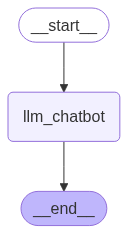

In [11]:
# adding nodes
graph_builder.add_node(
    "llm_chatbot", 
    chatbot
)

# adding edges
graph_builder.add_edge(START, "llm_chatbot")
graph_builder.add_edge("llm_chatbot", END)


# compilation
graph= graph_builder.compile()
graph

In [13]:
response= graph.invoke(
    {
        "messages": "Hi"
    }
)
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='23651a8f-1cfb-491f-ab76-d4d84dc1270a'),
  AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.044898716, 'prompt_time': 0.00151901, 'queue_time': 0.05277568, 'total_time': 0.046417726}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cf5fe54-c855-4dc5-873d-b0cf9735db3e-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})]}

In [17]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='23651a8f-1cfb-491f-ab76-d4d84dc1270a'),
 AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.044898716, 'prompt_time': 0.00151901, 'queue_time': 0.05277568, 'total_time': 0.046417726}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cf5fe54-c855-4dc5-873d-b0cf9735db3e-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})]

In [19]:
for event in graph.stream({
    "messages": "Nice to meet you as well ~~~"
}):
    # print(event)
    for value in event.values():
        print(value["messages"][-1].content)

It's nice to meet you too. Is there something I can help you with or would you like to chat?


## chatbot-with-tools

In [7]:
tools= []

In [8]:
from langchain_tavily import TavilySearch

tavily_tool= TavilySearch(
    max_results=2
)
tools.append(tavily_tool)

In [27]:
tavily_tool.invoke("vitalpeptides.us")

{'query': 'vitalpeptides.us',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.amazon.com/Vital-Proteins-Collagen-Peptides-Pasture-Raised/dp/B00K6JUG4K',
   'title': 'Vital Proteins Collagen Peptides Powder Advanced with Hyaluronic ...',
   'content': 'SUPPORTS COLLAGEN PRODUCTION: With 100% daily value of Vitamin C, this Vital Proteins Collagen Peptides Advanced Powder helps promote collagen production which',
   'score': 0.35180137,
   'raw_content': None},
  {'url': 'https://www.vitalproteins.com/products/collagen-peptides?srsltid=AfmBOorM_IcBBZFv5O9l4QwezG_cwURjW2ZH3ISCu0CdOJ6gvHqvc3EC',
   'title': 'Grass Fed Collagen Peptides Powder - Vital Proteins',
   'content': 'Our Collagen Peptides Advanced powder boasts hyaluronic acid and vitamin C, powerhouse ingredients that provide glowing wellness benefits.',
   'score': 0.30056128,
   'raw_content': None}],
 'response_time': 1.03}

In [9]:
# custom function 
def multiply(a:int, b:int) -> int:
    """_summary_

    Args:
        a (int): first number
        b (int): second number

    Returns:
        int: a*b
    """
    return a*b

tools.append(multiply)

In [10]:
tools

[TavilySearch(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None)),
 <function __main__.multiply(a: int, b: int) -> int>]

In [11]:
llm_with_tools= llm.bind_tools(
    tools
)

llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000024F1EC657F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024F1EC663C0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description':

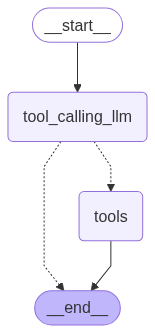

In [33]:

# StateGraph

# NODE definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
# Graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from assistant is tool call ---> route to tool()
    # else -----> route to END 
    tools_condition
)
builder.add_edge("tools", END)


# compile the graph
tool_call_graph= builder.compile()
tool_call_graph


In [49]:
response= tool_call_graph.invoke({
    "messages": "What are the vital peptides?"
})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are the vital peptides?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (q784q9xfy)
 Call ID: q784q9xfy
  Args:
    query: vital peptides
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "vital peptides", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.amazon.com/Vital-Proteins-Nutrition-Collagen-Peptides/dp/B083LDJNPK", "title": "Amazon.com: Vital Proteins Natural Whole Nutrition Collagen Peptides", "content": "5.   Image 41: Vital PROTEINS Collagen Peptides 20ct Box, 0.35 OZVital PROTEINS Collagen Peptides 20ct Box, 0.35 OZ_4.7 out of 5 stars_ 133  -12%$35.31$35.31($5.04/ounce) List:$39.99   Get it as soon as Tuesday, Jun 24  FREE Shipping by Amazon [...] 3.   Image 39: Vital Proteins Col

In [50]:
response= tool_call_graph.invoke({
    "messages": "What is -4 multiplied by 839647434.554 ?"
})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is -4 multiplied by 839647434.554 ?
================================== Ai Message ==================================
Tool Calls:
  multiply (fs3rw2zjz)
 Call ID: fs3rw2zjz
  Args:
    a: -4
    b: 839647435
================================= Tool Message =================================
Name: multiply

-3358589740
================================== Ai Message ==================================

The result of -4 multiplied by 839647434.554 is approximately -335889793.816.


In [51]:
response= tool_call_graph.invoke({
    "messages": "What is -4 multiplied by 839647434.554 and then 474.775 multiplied by the result ?"
})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is -4 multiplied by 839647434.554 and then 474.775 multiplied by the result ?
================================== Ai Message ==================================
Tool Calls:
  multiply (prg87qb3e)
 Call ID: prg87qb3e
  Args:
    a: -4
    b: 839647435
  multiply (9txrd20fa)
 Call ID: 9txrd20fa
  Args:
    a: 474
    b: -3378989742
================================= Tool Message =================================
Name: multiply

-3358589740
================================= Tool Message =================================
Name: multiply

-1601641137708
================================== Ai Message ==================================

The result of -4 multiplied by 839647434.554 is -335859738.216, then 474.775 multiplied by this result is -1601641137708.1376.


## Re-ACT Architechure
- multi-step-tools

In [12]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000024F1EC657F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024F1EC663C0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description':

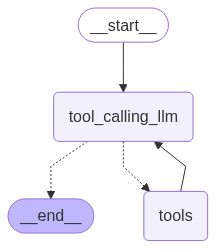

In [13]:

# StateGraph

# NODE definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
# Graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from assistant is tool call ---> route to tool()
    # else -----> route to END 
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")


# compile the graph
tool_call_graph= builder.compile()
tool_call_graph


In [54]:
response= graph.invoke({
    "messages": "Current president of usa,  The latest education minister of up, and What is -4 multiplied by 839647434.554 and then 474.775 multiplied by the result ?"
})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Current president of usa,  The latest education minister of up, and What is -4 multiplied by 839647434.554 and then 474.775 multiplied by the result ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (jv63zvb53)
 Call ID: jv63zvb53
  Args:
    query: Current president of USA
    topic: news
  tavily_search (np3r3xmm9)
 Call ID: np3r3xmm9
  Args:
    query: latest education minister of UP
    topic: news
  multiply (tjznjxapm)
 Call ID: tjznjxapm
  Args:
    a: -4
    b: 839647435
  multiply (bjqqj88sr)
 Call ID: bjqqj88sr
  Args:
    a: 474
    b: -3358987380
================================= Tool Message =================================
Name: tavily_search

{"query": "Current president of USA", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.usatoday.com/story/news/politics/2025/07/06/beshear-trump-me

## Adding Memory (`persistence checkpointing`)

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory= MemorySaver()
memory

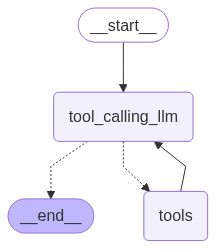

In [15]:

# StateGraph

# NODE definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
# Graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from assistant is tool call ---> route to tool()
    # else -----> route to END 
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")


# compile the graph
react_graph_with_memory= builder.compile(checkpointer=memory)
react_graph_with_memory


In [58]:
config= {
    "configurable": {
        "thread_id": "1"
    }
}


response= react_graph_with_memory.invoke(
    {"messages": "Hi i am deepankar and i am a dc fan"},
    config=config
)
response

{'messages': [HumanMessage(content='Hi i am deepankar and i am a dc fan', additional_kwargs={}, response_metadata={}, id='1d71ebcd-33b4-4152-ae16-063a4bb02f1f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'enjhw6qrp', 'function': {'arguments': '{"query":"DC Fan news","search_depth":"basic","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1284, 'total_tokens': 1315, 'completion_time': 0.160114515, 'prompt_time': 0.072130991, 'queue_time': 0.058133619, 'total_time': 0.232245506}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2abf3faa-22d3-44d6-8e79-6df5786d1586-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'DC Fan news', 'search_depth': 'basic', 'topic': 'general'}, 'id': 'enjhw6qrp', 'type': 'tool_call'}], usage_metadata={'input_tokens

In [60]:
response= react_graph_with_memory.invoke({
    "messages": "Hi do you remember me ? WHat should i watch this weekend?"
}, config=config
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi i am deepankar and i am a dc fan
================================== Ai Message ==================================
Tool Calls:
  tavily_search (enjhw6qrp)
 Call ID: enjhw6qrp
  Args:
    query: DC Fan news
    search_depth: basic
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "DC Fan news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://dccomicsnews.com/", "title": "DC Comics News: Home", "content": "DC Comics News is a leading fan site covering the latest News, Reviews, Previews and interviews covering the DC Universe.", "score": 0.78846955, "raw_content": null}, {"url": "https://www.dc.com/news", "title": "News - DC", "content": "Welcome to the Official Site for DC news. DC is home to the \"World's Greatest Super Heroes,\" including SUPERMAN, BATMAN, WONDER WOMAN, GREEN LANTERN,

In [ ]:
response= react_graph_with_memory.invoke({
    "messages": "Hi do you remember me ? WHat should i watch this weekend?"
}, config=config
)
for m in response["messages"]:
    m.pretty_print()

In [61]:
response= react_graph_with_memory.invoke({
    "messages": "watched them all , nothing new?"
}, config=config
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi i am deepankar and i am a dc fan
================================== Ai Message ==================================
Tool Calls:
  tavily_search (enjhw6qrp)
 Call ID: enjhw6qrp
  Args:
    query: DC Fan news
    search_depth: basic
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "DC Fan news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://dccomicsnews.com/", "title": "DC Comics News: Home", "content": "DC Comics News is a leading fan site covering the latest News, Reviews, Previews and interviews covering the DC Universe.", "score": 0.78846955, "raw_content": null}, {"url": "https://www.dc.com/news", "title": "News - DC", "content": "Welcome to the Official Site for DC news. DC is home to the \"World's Greatest Super Heroes,\" including SUPERMAN, BATMAN, WONDER WOMAN, GREEN LANTERN,

### chat-with-streaming

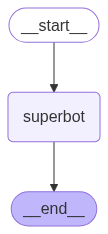

In [22]:
def superbot(state: State):
    return {
        "messages": [llm.invoke(state["messages"])]
    }
    
    
# memory
memory= MemorySaver()

graph= StateGraph(State)


# node
graph.add_node("superbot", superbot)

# edges
graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

# graph_builder
graph= graph.compile(checkpointer=memory)
graph

In [ ]:
# invocation
config= {
    "configurable": {"thread_id": "1"}
}

graph.invoke({"messages": "Hi I am doing alright"}, config=config)

{'messages': [HumanMessage(content='Hi I am doing alright', additional_kwargs={}, response_metadata={}, id='9dd98eb7-41fa-4922-baad-8ceb1e51242f'),
  AIMessage(content="It's nice to hear that you're doing alright. If you feel like talking about what's on your mind or need any help with something, I'm here to listen and assist you. How's your day been so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 40, 'total_tokens': 87, 'completion_time': 0.141774091, 'prompt_time': 0.001733169, 'queue_time': 0.052906172, 'total_time': 0.14350726}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ca5a0b83-522e-4ba8-889e-5d5cb8edd90f-0', usage_metadata={'input_tokens': 40, 'output_tokens': 47, 'total_tokens': 87})]}

In [24]:
# update invocation
config= {
    "configurable": {"thread_id": "2"}
}

for chunk in graph.stream({"messages": "How was the superman"}, config=config, stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="You're referring to the iconic superhero, Superman!\n\nSuperman is a legendary character created by Jerry Siegel and Joe Shuster. He first appeared in Action Comics #1 in 1938 and has since become one of the most recognizable and beloved superheroes of all time.\n\n**Origin Story:**\nSuperman's origin story begins on the planet Krypton, where he was born as Kal-El. As Krypton faced imminent destruction, Kal-El's parents, Jor-El and Lara, sent their infant son to Earth in a small spaceship moments before the planet exploded. The spaceship landed on a farm in Smallville, Kansas, where Kal-El was found and adopted by Jonathan and Martha Kent, who named him Clark Kent.\n\n**Powers and Abilities:**\nAs an alien from a planet with a much stronger sun and gravitational forces, Clark Kent developed incredible powers on Earth, including:\n\n1. **Super Strength**: Superman has incredible physical strength, capable of lifting massive objects and battl

In [26]:

for chunk in graph.stream({"messages": "How was the superman movie"}, config=config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='How was the superman', additional_kwargs={}, response_metadata={}, id='7e0f0552-7b82-4831-be9b-d885b34fd956'), AIMessage(content="You're referring to the iconic superhero, Superman!\n\nSuperman is a legendary character created by Jerry Siegel and Joe Shuster. He first appeared in Action Comics #1 in 1938 and has since become one of the most recognizable and beloved superheroes of all time.\n\n**Origin Story:**\nSuperman's origin story begins on the planet Krypton, where he was born as Kal-El. As Krypton faced imminent destruction, Kal-El's parents, Jor-El and Lara, sent their infant son to Earth in a small spaceship moments before the planet exploded. The spaceship landed on a farm in Smallville, Kansas, where Kal-El was found and adopted by Jonathan and Martha Kent, who named him Clark Kent.\n\n**Powers and Abilities:**\nAs an alien from a planet with a much stronger sun and gravitational forces, Clark Kent developed incredible powers on Earth, incl

In [27]:

for chunk in graph.stream({"messages": "I also liked batman"}, config=config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='How was the superman', additional_kwargs={}, response_metadata={}, id='7e0f0552-7b82-4831-be9b-d885b34fd956'), AIMessage(content="You're referring to the iconic superhero, Superman!\n\nSuperman is a legendary character created by Jerry Siegel and Joe Shuster. He first appeared in Action Comics #1 in 1938 and has since become one of the most recognizable and beloved superheroes of all time.\n\n**Origin Story:**\nSuperman's origin story begins on the planet Krypton, where he was born as Kal-El. As Krypton faced imminent destruction, Kal-El's parents, Jor-El and Lara, sent their infant son to Earth in a small spaceship moments before the planet exploded. The spaceship landed on a farm in Smallville, Kansas, where Kal-El was found and adopted by Jonathan and Martha Kent, who named him Clark Kent.\n\n**Powers and Abilities:**\nAs an alien from a planet with a much stronger sun and gravitational forces, Clark Kent developed incredible powers on Earth, incl